**Author:** Max Aragón<br>
**Professor:** Pierre-Francois Marteau<br>
**Affiliations:** Université Bretagne Sud<br>
**Course:** Similarity Spaces for Time series Mining <br>
**Date:** 2022-12-01

<div class="alert alert-block alert-success">
<h2><center>Time Elastic Kernels</center></h2>

## Question 1

Draw the alignment matrix allowing to evaluate the pairwise Levenshtein’s distance of the strings "aBigRedHat" and "aRedBigHat" with the following costs : i) deletion/insertion = 1, substitution = 2 (ai  ̸= bj ), match = 0 (ai = bj ). What do you observe in this matrix ?

In [2]:
import numpy as np

def levenshtein(seq1, seq2):
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
    print (matrix)
    return (matrix[size_x - 1, size_y - 1])

In [3]:
size_x = len('aBigRedHat') + 1
size_y = len('aRedBigHat') + 1
matrix = np.zeros ((size_x, size_y))
for x in range(size_x):
    matrix [x, 0] = x
for y in range(size_y):
    matrix [0, y] = y

In [4]:
levenshtein('aBigRedHat', 'aRedBigHat')

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 2.  1.  1.  2.  3.  3.  4.  5.  6.  7.  8.]
 [ 3.  2.  2.  2.  3.  4.  3.  4.  5.  6.  7.]
 [ 4.  3.  3.  3.  3.  4.  4.  3.  4.  5.  6.]
 [ 5.  4.  3.  4.  4.  4.  5.  4.  4.  5.  6.]
 [ 6.  5.  4.  3.  4.  5.  5.  5.  5.  5.  6.]
 [ 7.  6.  5.  4.  3.  4.  5.  6.  6.  6.  6.]
 [ 8.  7.  6.  5.  4.  4.  5.  6.  6.  7.  7.]
 [ 9.  8.  7.  6.  5.  5.  5.  6.  7.  6.  7.]
 [10.  9.  8.  7.  6.  6.  6.  6.  7.  7.  6.]]


6.0

Results: As expected, total Levenshtein distance is 6, representing the minimum number of single-character edits required to change one word into the other. 

## Question 2

The aim of this lab exercise is to evaluate "time elastic" distances on some hand-written signature database. We will use the MOBISIG data that contains finger-drawn pseudosignatures from 83 users captured with a capacitive touchscreen-based mobile device. The database was captured in three sessions resulting in 45 genuine signatures and 20 skilled forgeries for each user. More info on MOBISIG is available at https://www.hindawi.com/journals/misy/2018/3127042/.
Each signature is represented as a sequence of points and is stored in a file. Each line of the file represents one point of the signature and consists of the following features:

+ x-coordinate, y-coordinate.
+ time stamp, pressure, finger area.
+ x-velocity, y-velocity.
+ x-acceleration, y- acceleration, z-acceleration. 
+ x-gyroscope, y-gyroscope, z-gyroscope.

The data loader considers only five features x-coordinate, y-coordinate, pressure, x-velocity and y- velocity.

i) Download the MOBISIG data and the available python codes (data loader, dtw and Frechet’s distances) from https://moodle.univ-ubs.fr/course/view.php?id=6435, unzip the archive in a working directory and test the data loader code.

ii) The data loader loads in sequence 83 classification tasks, one for each user. Each tasks consists in:
+ Training set composed with genuine signatures (X_train)
+ Testing set composed with a mix of genuine and forge signatures (X_test) 
+ List of expected labels (y_test) to evaluate classification methods.

Test the correct loading of the data by plotting some signatures in 2D (x-coordinate, y-coordinate).
Develop a python program to process in sequence all these 83 tasks. We will first consider 1-NN classifiers based on the Euclidean distance (ED), the DTW distance and The Frechet’s distance.

![alt text](https://rtavenar.github.io/blog/fig/dtw_vs_euc.svg)

In [1]:
!pip install dtw-python

In [2]:
import os
import glob
import time

# Professor scripts
os.chdir('/Users/max/Desktop/UBS/Kernels/')
import processMobisig
import dfrechet
import kdtw
import eer


## Other packages 
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
#from sklearn import metrics
import pathlib
import numpy as np
import pandas as pd
import random
import draw
import dtw

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Split data

In [3]:
# set the correct path
path0 = '/Users/max/Desktop/UBS/Kernels/'
path=path0 + 'MOBISIG/'
os.chdir(path)
print('path:',path)
luid = glob.glob("USER*")
luid.sort()

# load first USER data
uid=luid[0]
print(path0)
X_train, X_test, y_test = processMobisig.loadTrainQuestionnedMOBISIG(uid, ntrain=5, path=path)

path: /Users/max/Desktop/UBS/Kernels/MOBISIG/
/Users/max/Desktop/UBS/Kernels/


## View signatures (2D)

In [4]:
def view_signatures():
    ntrain = 5
    users_index = [random.randint(0, 60) for p in range(0, 5)]
    
    path= '/Users/max/Desktop/UBS/Kernels/MOBISIG'
    luid = [str(x) for x in pathlib.Path(path).glob("USER*")]

    # Load the dataset
    def load_data(idx):
        x_train, x_test = processMobisig.loadTrainQuestionnedMOBISIG(luid[idx], ntrain=ntrain, path="")[0:2]
        return x_train[1], x_test[1]

    # genuine signature
    fig, axs = plt.subplots(1, 5, figsize = (20, 5), sharey=True, sharex=True)
    for i, ax in zip(users_index, axs.ravel()):
        real = load_data(i)[0]
        plt.plot(real[:, 0], real[:, 1], c = "blue")
        plt.title("Real Signature")
        plt.sca(ax=ax)
    
    # forged signature
    fig, axes = plt.subplots(1, 5, figsize = (20, 5))
    for i, ax in zip(users_index, axes.ravel()):
        fake = load_data(i)[1]
        plt.plot(fake[:, 0], fake[:, 1], c = 'red')
        plt.title("False Signature")
        plt.sca(ax=ax)

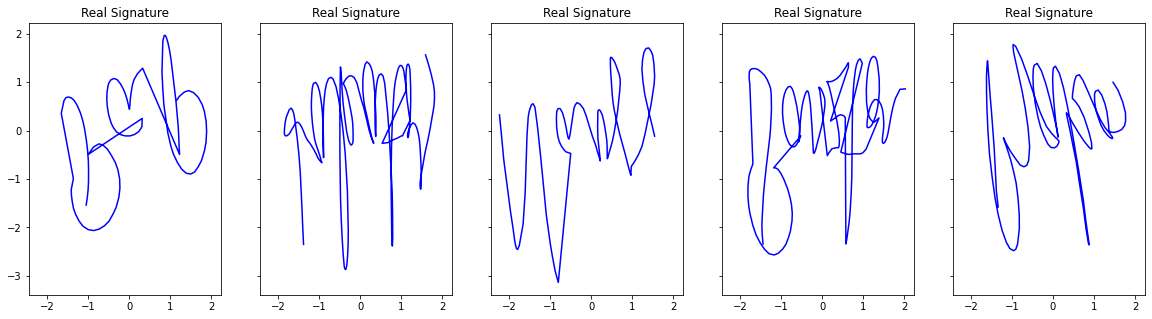

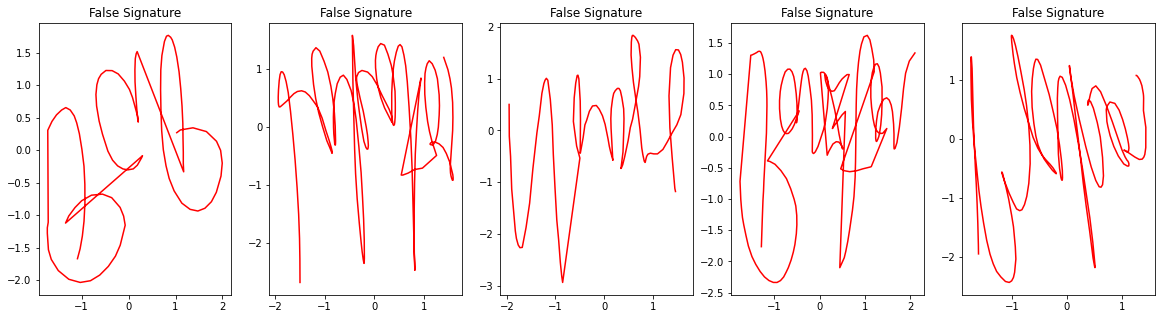

In [5]:
view_signatures()

## Compute distances

In [5]:
def array_mean(arrs, index_features):
    lens = [len(i) for i in arrs]
    base_arr = np.full((np.max(lens),len(arrs)), np.nan)
    mean_list = []
    sd_list = []
    for indexf in index_features:
        barr = base_arr.copy()
        arrl = [arr[:,indexf] for arr in arrs]        
        for idx, l in enumerate(arrl):
            barr[:len(l), idx] = l
        mean_list.append(np.nanmean(barr, axis = -1))
        sd_list.append(np.nanstd(barr, axis=-1))
    return np.stack(mean_list, axis=-1), np.stack(sd_list, axis=-1)


def processProblem(X_train, X_test, y_test, features=['x', 'y', 'pressure'], dis='euclidean', kdtw_sigma=10.0):
    # 1-NN Classifier
    # signature features
    tffeatures = {'x': 0, 'y': 1, 'pressure': 2, 'x_velocity': 3, 'y_velocity': 4}
    index_features = [tffeatures[ft] for ft in features]

    #Convert np.array(np.array) to list(np.array)  filter according to features
    train_arrs = X_train.tolist()
    train_narrs = [arr[:, index_features] for arr in train_arrs]

    test_arrs = X_test.tolist()
    test_narrs = [arr[:, index_features] for arr in test_arrs]
    
    y_test = [0 if value == 'F' else 1 for value in y_test]
    
    #merge all the train signatures
    mean_sign, error = array_mean(arrs = train_narrs, index_features = index_features)
    
    #Estimate the similarity with Xtest dataset
    if dis == 'euclidean':
        final_feature = []
        for test_narr in test_narrs:          
            min_distance = []
            for point in mean_sign:
                mind = np.min(np.sqrt(np.apply_along_axis(np.sum, 1, (point - test_narr)**2)))
                min_distance.append(mind)
            final_feature.append(np.mean(np.array(min_distance)))
        final_feature_np = np.array(final_feature)
    elif dis == 'frechet':
        final_feature = []
        for  test_narr in test_narrs:
            frechet_dist = dfrechet.frechet(mean_sign, test_narr)
            final_feature.append(frechet_dist)
        final_feature_np = np.array(final_feature)
    if dis == 'dtw':
        final_feature = []
        dtw_dist = [dtw.dtw(test_narr, mean_sign, distance_only=True) for test_narr in test_narrs]
        for dist in dtw_dist:
            final_feature.append(dist.distance)
        final_feature_np = np.array(final_feature)
    if dis == 'kdtw':
        final_feature = []
        for  test_narr in test_narrs:
            kdtw_dist = kdtw.kdtw(mean_sign, test_narr, sigma = kdtw_sigma)
            final_feature.append(kdtw_dist)
        final_feature_np = np.array(final_feature)

    return final_feature_np, y_test

def estimate_distance(luid, ntrain=5, features=['x', 'y'], dis='euclidean', outputdir='/Users/max/Desktop/UBS/Kernels'):
    results_list = []
    start = time.time()
    for uid in luid:
        X_train, X_test, y_test = processMobisig.loadTrainQuestionnedMOBISIG(uid, ntrain=ntrain, path="")    
        x, target = processProblem(X_train, X_test, y_test, features = features, dis = dis)
        userID = uid.split('/')[-1]
        results_list.append(pd.DataFrame({'user': userID, 'distance': x, 'label': target}))
    end = time.time()
    total_time = (end-start)/60
    print(f'Done calculating {dis} after {total_time} minutes')
    results_df = pd.concat(results_list)
    output = "%s/%s_results.csv" % (outputdir , dis)
    results_df.to_csv(output)
    return True

<div class="alert alert-block alert-warning"><b> Warning! Next cell calculates distances thus takes long time </b>  </div>

In [6]:
luid = glob.glob(os.path.join(os.path.dirname(path), 'USER*'));

 
estimate_distance(luid, ntrain=5, features=['x', 'y'], dis='euclidean')
estimate_distance(luid, ntrain=5, features=['x', 'y'], dis='frechet')
estimate_distance(luid, ntrain=5, features=['x', 'y'], dis='dtw')
estimate_distance(luid, ntrain=5, features=['x', 'y'], dis='kdtw')

Done calculating euclidean after 23.82439101934433 minutes
Done calculating frechet after 38.86753120024999 minutes
Done calculating dtw after 0.2962069153785706 minutes
Done calculating kdtw after 8.069180417060853 minutes


True

# Evaluate classifiers

In [6]:
from sklearn.metrics import roc_auc_score, average_precision_score,roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
# Suppress the 0/0 warning
np.seterr(invalid='ignore')
import collections
import pickle

def user_name(dataset):
    user_column = dataset.user.replace("USER", "", regex=True)
    dataset.user = pd.Series(["USER%02d" % int(user_column[i]) for i in range(len(dataset.user))])
    return dataset

def eer(y_true,y_pred):
    fpr, tpr, threshold = roc_curve(y_true, y_pred, pos_label=1)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
    return fpr[np.nanargmin(np.absolute((fnr - fpr)))]

def matrix_metric(model, dataset, metric='auc'):
    dataset = pd.read_csv(dataset)
    dataset = user_name(dataset)
    users = list(set(dataset['user']))
 
    results = dict()
    for user in users:
        #  training
        train = dataset[dataset.user == user]
        X, y = train['distance'].to_numpy().reshape(-1, 1), train['label']    
        model.fit(X, y)
        
        # Create a test set excluding the current user (82 len)
        test_users = [xuser for xuser in users if not user in xuser]
        #  Evaluate your model on the other users
        test_results = list()
        for test_user in test_users:
            test = dataset[dataset.user == test_user]
            Xtest, ytest = test['distance'].to_numpy().reshape(-1, 1), test['label']
            ypred = model.predict(Xtest)
            if metric == 'auc':
                fpr, tpr, _ = roc_curve(ytest, ypred)
                rmetric = metrics.auc(fpr, tpr)
            elif metric == 'ap':
                rmetric = average_precision_score(ytest, ypred)
            elif metric == 'eer':
                rmetric = eer(ytest,ypred)
                #rmetric = average_precision_score(ypred, ytest)
            #else:
                #eer(ytest, ypred)
                #pass
            test_results.append(rmetric)
        user_index = int(user.replace("USER", "")) - 1
        test_results.insert(user_index, -999)
        results.update({user:test_results})
    od = collections.OrderedDict(sorted(results.items()))
    return pd.DataFrame(od)        

def create_matrices():
    neigh = KNeighborsClassifier(n_neighbors=2)
    hmetrics = ['auc', 'ap', 'eer']

    matrix_evaluation_euclidean = list()
    for metric in hmetrics:
        matrix_evaluation_euclidean.append(matrix_metric(neigh, '/Users/max/Desktop/UBS/Kernels/euclidean_results.csv', metric = metric))
    matrix_evaluation_euclidean =  {'auc': matrix_evaluation_euclidean[0], 'ap': matrix_evaluation_euclidean[1], 'eer': matrix_evaluation_euclidean[2]}

    matrix_evaluation_frechet = list()
    for metric in hmetrics:
        matrix_evaluation_frechet.append(matrix_metric(neigh, '/Users/max/Desktop/UBS/Kernels/frechet_results.csv', metric = metric))
    matrix_evaluation_frechet =  {'auc': matrix_evaluation_frechet[0], 'ap': matrix_evaluation_frechet[1], 'eer': matrix_evaluation_frechet[2]}

    matrix_evaluation_kdtw = list()
    for metric in hmetrics:
        matrix_evaluation_kdtw.append(matrix_metric(neigh, '/Users/max/Desktop/UBS/Kernels/euclidean_results.csv', metric = metric))
    matrix_evaluation_kdtw =  {'auc': matrix_evaluation_kdtw[0], 'ap': matrix_evaluation_kdtw[1], 'eer': matrix_evaluation_kdtw[2]}

    matrix_evaluation_dtw = list()
    for metric in hmetrics:
        matrix_evaluation_dtw.append(matrix_metric(neigh, '/Users/max/Desktop/UBS/Kernels/dtw_results.csv', metric = metric))
    matrix_evaluation_dtw =  {'auc': matrix_evaluation_dtw[0], 'ap': matrix_evaluation_dtw[1], 'eer': matrix_evaluation_dtw[2]}

    return {
        'matrix_evaluation_euclidean': matrix_evaluation_euclidean,
        'matrix_evaluation_frechet': matrix_evaluation_frechet,
        'matrix_evaluation_dtw': matrix_evaluation_dtw,
        'matrix_evaluation_kdtw': matrix_evaluation_kdtw,
    }

In [7]:
neigh = KNeighborsClassifier(n_neighbors=2)
hmetrics = ['auc', 'ap', 'eer']

# Euclidean

matrix_evaluation_euclidean = list()
for metric in hmetrics:
    matrix_evaluation_euclidean.append(matrix_metric(neigh, '/Users/max/Desktop/UBS/Kernels/euclidean_results.csv', metric = metric))
matrix_evaluation_euclidean =  {'auc': matrix_evaluation_euclidean[0], 'ap': matrix_evaluation_euclidean[1], 'eer': matrix_evaluation_euclidean[2]}

# Frechet

matrix_evaluation_frechet = list()
for metric in hmetrics:
    matrix_evaluation_frechet.append(matrix_metric(neigh, '/Users/max/Desktop/UBS/Kernels/frechet_results.csv', metric = metric))
matrix_evaluation_frechet =  {'auc': matrix_evaluation_frechet[0], 'ap': matrix_evaluation_frechet[1], 'eer': matrix_evaluation_frechet[2]}

# KDTW

matrix_evaluation_kdtw = list()
for metric in hmetrics:
    matrix_evaluation_kdtw.append(matrix_metric(neigh, '/Users/max/Desktop/UBS/Kernels/kdtw_results.csv', metric = metric))
matrix_evaluation_kdtw =  {'auc': matrix_evaluation_kdtw[0], 'ap': matrix_evaluation_kdtw[1], 'eer': matrix_evaluation_kdtw[2]}

# DTW

matrix_evaluation_dtw = list()
for metric in hmetrics:
    matrix_evaluation_dtw.append(matrix_metric(neigh, '/Users/max/Desktop/UBS/Kernels/dtw_results.csv', metric = metric))
matrix_evaluation_dtw =  {'auc': matrix_evaluation_dtw[0], 'ap': matrix_evaluation_dtw[1], 'eer': matrix_evaluation_dtw[2]}

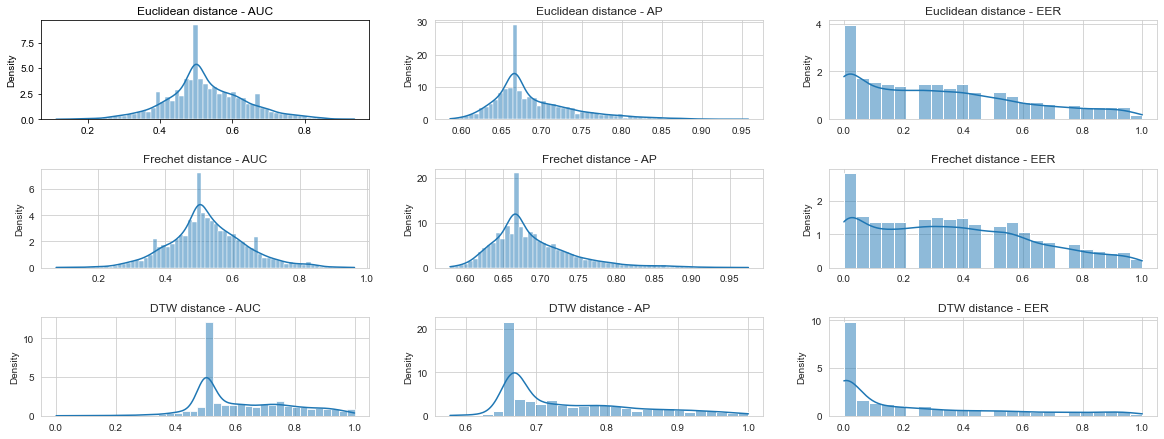

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(20,10))

fig.subplots_adjust(hspace=0.5)

# EUCLIDEAN 
plt.subplot(431)
eu_auc = matrix_evaluation_euclidean['auc'].to_numpy().flatten()
eu_auc[eu_auc == - 999] = np.nan  #since the first user is -999
sns.set_style('whitegrid')
sns.histplot(eu_auc, kde=True, stat="density")
plt.title("Euclidean distance - AUC")

plt.subplot(432)
eu_ap = matrix_evaluation_euclidean['ap'].to_numpy().flatten()
eu_ap[eu_ap == - 999] = np.nan
sns.set_style('whitegrid')
sns.histplot(eu_ap, kde=True, stat="density")
plt.title("Euclidean distance - AP")

plt.subplot(433)
eu_eer = matrix_evaluation_euclidean['eer'].to_numpy().flatten()
eu_eer[eu_eer == - 999] = np.nan
sns.set_style('whitegrid')
sns.histplot(eu_eer, kde=True, stat="density")
plt.title("Euclidean distance - EER")

# FRECHET
plt.subplot(434)
fr_auc = matrix_evaluation_frechet['auc'].to_numpy().flatten()
fr_auc[fr_auc == - 999] = np.nan
#plt.hist(fr_auc)
sns.histplot(fr_auc, kde=True, stat="density")
plt.title("Frechet distance - AUC")

plt.subplot(435)
fr_ap = matrix_evaluation_frechet['ap'].to_numpy().flatten()
fr_ap[fr_ap == - 999] = np.nan
sns.histplot(fr_ap, kde=True, stat="density")
#plt.hist(fr_ap)
plt.title("Frechet distance - AP")

plt.subplot(436)
fr_eer = matrix_evaluation_frechet['eer'].to_numpy().flatten()
fr_eer[fr_eer == - 999] = np.nan
#plt.hist(fr_eer)
sns.histplot(fr_eer, kde=True, stat="density")
plt.title("Frechet distance - EER")


# DTW
plt.subplot(437)
dtw_auc = matrix_evaluation_dtw['auc'].to_numpy().flatten()
dtw_auc[dtw_auc == - 999] = np.nan
#plt.hist(dtw_auc, label='DTW')
sns.histplot(dtw_auc, kde=True, stat="density", label='DTW')
plt.title("DTW distance - AUC")



plt.subplot(438)
dtw_ap = matrix_evaluation_dtw['ap'].to_numpy().flatten()
dtw_ap[dtw_ap == - 999] = np.nan
#plt.hist(dtw_ap, label='DTW')
sns.histplot(dtw_ap, kde=True, stat="density", label='DTW')
plt.title("DTW distance - AP")



plt.subplot(439)
dtw_eer = matrix_evaluation_dtw['eer'].to_numpy().flatten()
dtw_eer[dtw_eer == - 999] = np.nan
#plt.hist(dtw_eer, label='DTW')
sns.histplot(dtw_eer, kde=True, stat="density", label='DTW')
plt.title("DTW distance - EER")




plt.show()

## **Question 3**

Download the KDTW python code from from https://github.com/pfmarteau/KDTW

Implement a cross-validation procedure to tune the meta parameter σ defined in KDTW. We will use the first USER (first task) to ’optimize’ this parameters, and test KDTW with this fixed setting following the procedure setup for Question 1 (provide the mean and standard deviation for the 3 evaluation measures calculated on the 82 remaining tasks). Provide also the (Method v.s. TaskID) matrices for KDTW.
Evaluate also the processing elapsed time for KDTW.


In [ ]:
# sigma value using cross-validation
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.utils import shuffle

kdtw_sigmas = [0.1, 0.5, 1, 2.5, 5, 7, 10, 12, 15]

# Create the dataset for USER1 
#path = "/content/drive/MyDrive/Colab Notebooks/MOBISIG"
path0 = '/Users/max/Desktop/UBS/Kernels/'
path=path0 + 'MOBISIG/'
ntrain = 5
luid = [str(x) for x in pathlib.Path(path).glob("USER*")]
X_train, X_test, y_test = processMobisig.loadTrainQuestionnedMOBISIG(luid[0], ntrain=ntrain, path="")
X_test, y_test = shuffle(X_test, y_test, random_state=0)

# Estimate Kfolds
kf = KFold(n_splits=5, shuffle=True)

results_byfold = list()
for train_indices, test_indices in kf.split(y_test):
    print('Train: %s | test: %s' % (train_indices, test_indices))
    best_score = dict()

    # train 
    xtrain = np.array([X_test[i] for i in train_indices], dtype=object)
    ytrain = np.array([y_test[i] for i in train_indices], dtype=object)
      
    # test 
    xtest = np.array([X_test[i] for i in test_indices], dtype=object)
    ytest = np.array([y_test[i] for i in test_indices], dtype=object)

    for sigma in kdtw_sigmas:

        xtrain01, ytrain01 = processProblem(X_train, xtrain, ytrain, features = ['x', 'y'], dis = 'kdtw', kdtw_sigma=sigma)
        xtest01, ytest01 = processProblem(X_train, xtest, ytest, features = ['x', 'y'], dis = 'kdtw', kdtw_sigma=sigma)
        
        # model evaluation
        clf = KNeighborsClassifier(n_neighbors=2).fit(xtrain01.reshape(-1, 1), ytrain01)
        score = clf.score(xtest01.reshape(-1, 1), ytest01)
        
        # save score
        best_score.update({sigma:score})
    results_byfold.append(best_score)

best_vparam = {sigma:np.mean([kfold[sigma] for kfold in results_byfold]) for sigma in kdtw_sigmas}

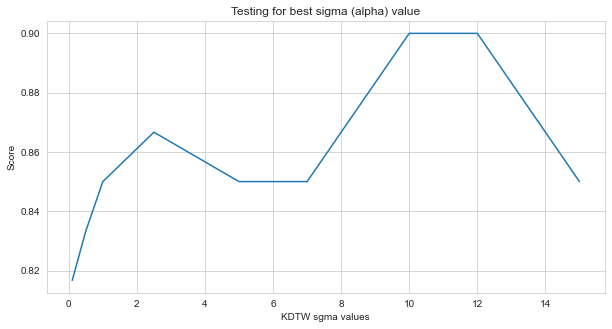

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(list(best_vparam),best_vparam.values())
plt.title('Testing for best sigma (alpha) value')
ax.set_ylabel('Score')
ax.set_xlabel('KDTW sgma values')
plt.show()

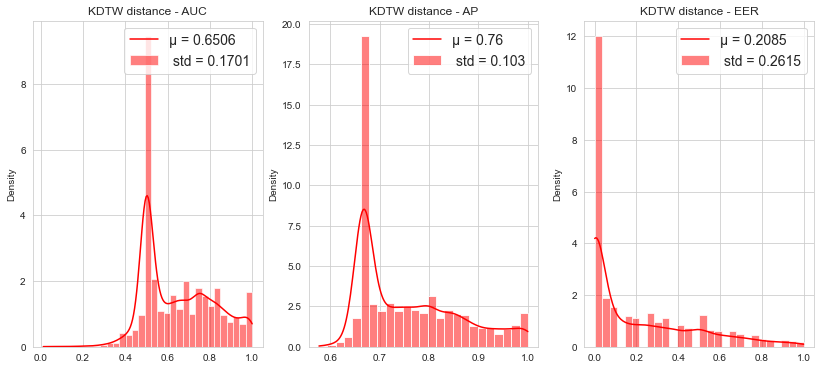

In [11]:
fig = plt.figure(figsize=(14,6))

fig.subplots_adjust(hspace=0.5)

# KDTW
plt.subplot(1,3,1)
kdtw_auc = matrix_evaluation_kdtw['auc'].to_numpy().flatten()
kdtw_auc[kdtw_auc == - 999] = np.nan
m1 = np.nanmean(kdtw_auc);  m1 = round(m1,4)
st = np.nanstd(kdtw_auc); st = round(st,4)
sns.histplot(kdtw_auc, kde=True, stat="density", color='red')
plt.legend(labels=[f'μ = {m1}', f' std = {st}'], fontsize=14)
plt.title("KDTW distance - AUC")



plt.subplot(1,3,2)
kdtw_ap = matrix_evaluation_kdtw['ap'].to_numpy().flatten()
kdtw_ap[kdtw_ap == - 999] = np.nan
m1 = np.nanmean(kdtw_ap);  m1 = round(m1,4)
st = np.nanstd(kdtw_ap); st = round(st,4)
sns.histplot(kdtw_ap, kde=True, stat="density",  label=f'μ = {m1}', color='red')
plt.legend(labels=[f'μ = {m1}', f' std = {st}'], fontsize=14)
plt.title("KDTW distance - AP")



plt.subplot(1,3,3)
kdtw_eer = matrix_evaluation_kdtw['eer'].to_numpy().flatten()
kdtw_eer[kdtw_eer == - 999] = np.nan
m1 = np.nanmean(kdtw_eer);  m1 = round(m1,4)
st = np.nanstd(kdtw_eer); st = round(st,4)
sns.histplot(kdtw_eer, kde=True, stat="density", color='red', label=f'μ = {m1}')
plt.legend(labels=[f'μ = {m1}', f' std = {st}'], fontsize=14)
plt.title("KDTW distance - EER")


plt.show()

# Question 4

Using the (Method v.s. TaskID) matrices, and the Critical Difference Diagrams package (Fried- man’s test followed by a post-hoc analysis based on the Wilcoxon-Holm method) https://github. com/hfawaz/cd-diagram, rank the four tested classifiers according to the Friedman’s tests and Nemenyi’s post-hoc test on the basis of the 82 classification tasks (without exploiting USER 1).

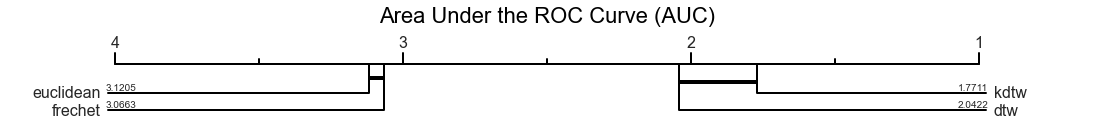

In [16]:
# euclidian
mean_AUC = matrix_evaluation_euclidean['auc'].apply(np.nanmedian)
dataset_name = np.array(mean_AUC.index)
classifier_name = 'euclidean'
euclidean= pd.DataFrame({'classifier_name':classifier_name, 'dataset_name':dataset_name, 'accuracy':mean_AUC})

# frechet
mean_AUC = matrix_evaluation_frechet['auc'].apply(np.nanmedian)
dataset_name = np.array(mean_AUC.index)
classifier_name = 'frechet'
frechet = pd.DataFrame({'classifier_name':classifier_name, 'dataset_name':dataset_name, 'accuracy':mean_AUC})

# DTW
mean_AUC = matrix_evaluation_dtw['auc'].apply(np.nanmedian)
dataset_name = np.array(mean_AUC.index)
classifier_name = 'dtw'
dtw= pd.DataFrame({'classifier_name':classifier_name, 'dataset_name':dataset_name, 'accuracy':mean_AUC})

# KDTW
mean_AUC = matrix_evaluation_kdtw['auc'].apply(np.nanmedian)
dataset_name = np.array(mean_AUC.index)
classifier_name = 'kdtw'
kdtw= pd.DataFrame({'classifier_name':classifier_name, 'dataset_name':dataset_name, 'accuracy':mean_AUC})

final= pd.concat([euclidean, frechet, dtw, kdtw])

draw.draw_cd_diagram(df_perf=final, title='Area Under the ROC Curve (AUC)', labels=True)

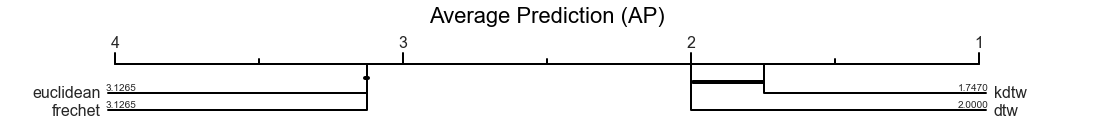

In [21]:
# euclidian
mean_AP = matrix_evaluation_euclidean['ap'].apply(np.nanmedian)
dataset_name = np.array(mean_AP.index)
classifier_name = 'euclidean'
euclidean= pd.DataFrame({'classifier_name':classifier_name, 'dataset_name':dataset_name, 'accuracy':mean_AP})

# frechet
mean_AP = matrix_evaluation_frechet['ap'].apply(np.nanmedian)
dataset_name = np.array(mean_AP.index)
classifier_name = 'frechet'
frechet = pd.DataFrame({'classifier_name':classifier_name, 'dataset_name':dataset_name, 'accuracy':mean_AP})

# DTW
mean_AP = matrix_evaluation_dtw['ap'].apply(np.nanmedian)
dataset_name = np.array(mean_AP.index)
classifier_name = 'dtw'
dtw= pd.DataFrame({'classifier_name':classifier_name, 'dataset_name':dataset_name, 'accuracy':mean_AP})

# KDTW
mean_AP = matrix_evaluation_kdtw['ap'].apply(np.nanmedian)
dataset_name = np.array(mean_AP.index)
classifier_name = 'kdtw'
kdtw= pd.DataFrame({'classifier_name':classifier_name, 'dataset_name':dataset_name, 'accuracy':mean_AP})

final_AP= pd.concat([euclidean, frechet, dtw, kdtw])

draw.draw_cd_diagram(df_perf=final_AP, title='Average Prediction (AP)', labels=True)

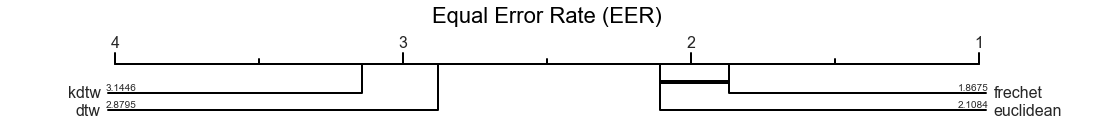

In [20]:
# euclidian
mean_EER = matrix_evaluation_euclidean['eer'].apply(np.nanmedian)
dataset_name = np.array(mean_EER.index)
classifier_name = 'euclidean'
euclidean= pd.DataFrame({'classifier_name':classifier_name, 'dataset_name':dataset_name, 'accuracy':mean_EER})

# frechet
mean_EER = matrix_evaluation_frechet['eer'].apply(np.nanmedian)
dataset_name = np.array(mean_EER.index)
classifier_name = 'frechet'
frechet = pd.DataFrame({'classifier_name':classifier_name, 'dataset_name':dataset_name, 'accuracy':mean_EER})

# DTW
mean_EER = matrix_evaluation_dtw['eer'].apply(np.nanmedian)
dataset_name = np.array(mean_EER.index)
classifier_name = 'dtw'
dtw= pd.DataFrame({'classifier_name':classifier_name, 'dataset_name':dataset_name, 'accuracy':mean_EER})

# KDTW
mean_EER = matrix_evaluation_kdtw['eer'].apply(np.nanmedian)
dataset_name = np.array(mean_EER.index)
classifier_name = 'kdtw'
kdtw= pd.DataFrame({'classifier_name':classifier_name, 'dataset_name':dataset_name, 'accuracy':mean_EER})

final_EER= pd.concat([euclidean, frechet, dtw, kdtw])

draw.draw_cd_diagram(df_perf=final_EER, title='Equal Error Rate (EER)', labels=True)

## Question 5 

Imagine and propose a semi-supervised procedure (exploiting only the training data) to tune the
KDTW sigma meta-parameter (minprob being fixed). Implement it and evaluate it. 

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import kdtw

# Set the range of sigma values to test
sigma_range = np.arange(0.1, 5.0, 0.1)

# Initialize an empty list to store the performance results
performance = []

# Iterate over the range of sigma values
for sigma in sigma_range:
    # Create a KDTW object with the current sigma value
    kdtw = kdtw(sigma=sigma)

    # Compute the performance of the KDTW algorithm on the training data
    perf = accuracy_score(train_labels, kdtw.predict(train_data))

    # Append the performance result to the list
    performance.append(perf)

# Find the sigma value that maximizes the performance of the KDTW algorithm
optimal_sigma = sigma_range[np.argmax(performance)]

# Create a KDTW object with the optimal sigma value
kdtw = kdtw(sigma=optimal_sigma)

# Train the KDTW algorithm on the full training data
kdtw.fit(train_data, train_labels)

# Evaluate the KDTW algorithm on the test data
predictions = kdtw.predict(test_data)

# Print the accuracy of the KDTW algorithm on the test data
print(accuracy_score(test_labels, predictions))

KDTW algorithm is trained on the full training data using the optimal sigma value that was determined earlier. The trained KDTW model is then used to make predictions on the test data, and the accuracy of these predictions is printed to the console.

This semi-supervised procedure can be used to tune the KDTW sigma meta-parameter in a way that maximizes the performance of the KDTW algorithm on the training data, without using any labeled test data. This can be useful when only a small amount of labeled data is available, and it can help to improve the performance of the KDTW algorithm.

# Conclusion

The use of time elastic distances, such as DTW, KDTW, and Frechet distance, can be effective in the context of hand-written signature verification. These distances are able to capture the temporal variations in the signatures and can provide more accurate results than the Euclidean distance, which does not take into account the temporal variations.

However, there are some challenges in using these distances for signature verification. One of the main challenges is the computational complexity of the distances, which can be high for large datasets. Another challenge is the sensitivity of the distances to the choice of parameters, such as the warping window size in DTW or the sigma parameter in KDTW.

To improve the classification performance of these distances, one possible approach is to use regularization techniques to reduce the sensitivity to the choice of parameters, such as in KDTW. Another approach is to use feature engineering techniques to extract more relevant features from the signatures that can improve the performance of the distances. Additionally, using ensemble methods, such as bagging or boosting, can also improve the performance by combining the predictions of multiple models trained on different subsets of the data.